# TVB for Epilepsy


### Basic configurations

In [1]:
!source activate python2.7.3
# !source activate python2_7

%matplotlib inline

import resource 
resource.setrlimit(resource.RLIMIT_NOFILE, (1000, -1))

import sys
stdout = sys.stdout

import os

import numpy as np
from tvb_epilepsy.base.constants.config import Config
from tvb_epilepsy.base.utils.log_error_utils import initialize_logger
from tvb_epilepsy.io.tvb_data_reader import TVBReader
from tvb_epilepsy.io.h5_reader import H5Reader
from tvb_epilepsy.io.h5_writer import H5Writer
from tvb_epilepsy.plot.plotter import Plotter

input_folder = os.path.join(os.path.expanduser("~"), 'Dropbox', 'Work', 'VBtech', 'VEP', "results", "CC", "TVB3", "tvb")
head_folder = os.path.join(os.path.expanduser("~"), 'Dropbox', 'Work', 'VBtech', 'VEP', "results", "CC", "TVB3", "Head")
# input_folder = os.path.join(os.path.expanduser("~"), 'Dropbox', 'Work', 'VBtech', 'VEP', "results", "INS", "TREC", "TREC88HH")
# head_folder = os.path.join(os.path.expanduser("~"), 'Dropbox', 'Work', 'VBtech', 'VEP', "results", "INS", "TREC", "TREC88HH", "Head")
output_folder = os.path.join(os.path.expanduser("~"), 'Dropbox', 'Work', 'VBtech', 'VEP', "results", "notebook")
seeg_data = os.path.join(os.path.expanduser("~"), 'Dropbox', 'Work', 'VBtech', 'VEP', "data/CC", "TVB3", "raw/seeg/ts_seizure")
config = Config(head_folder=input_folder, output_base=output_folder, data_mode="tvb", raw_data_folder=seeg_data) #, data_mode="java"
config.hypothesis.head_folder = head_folder
config.figures.MATPLOTLIB_BACKEND="inline"
config.figures.SHOW_FLAG=True
logger = initialize_logger(__name__, config.out.FOLDER_LOGS)
reader = TVBReader() if config.input.IS_TVB_MODE else H5Reader()
writer = H5Writer()
plotter = Plotter(config)
sys.stdout = stdout

# BASIC WORKFLOW 

### Read data from tvb or Head folder

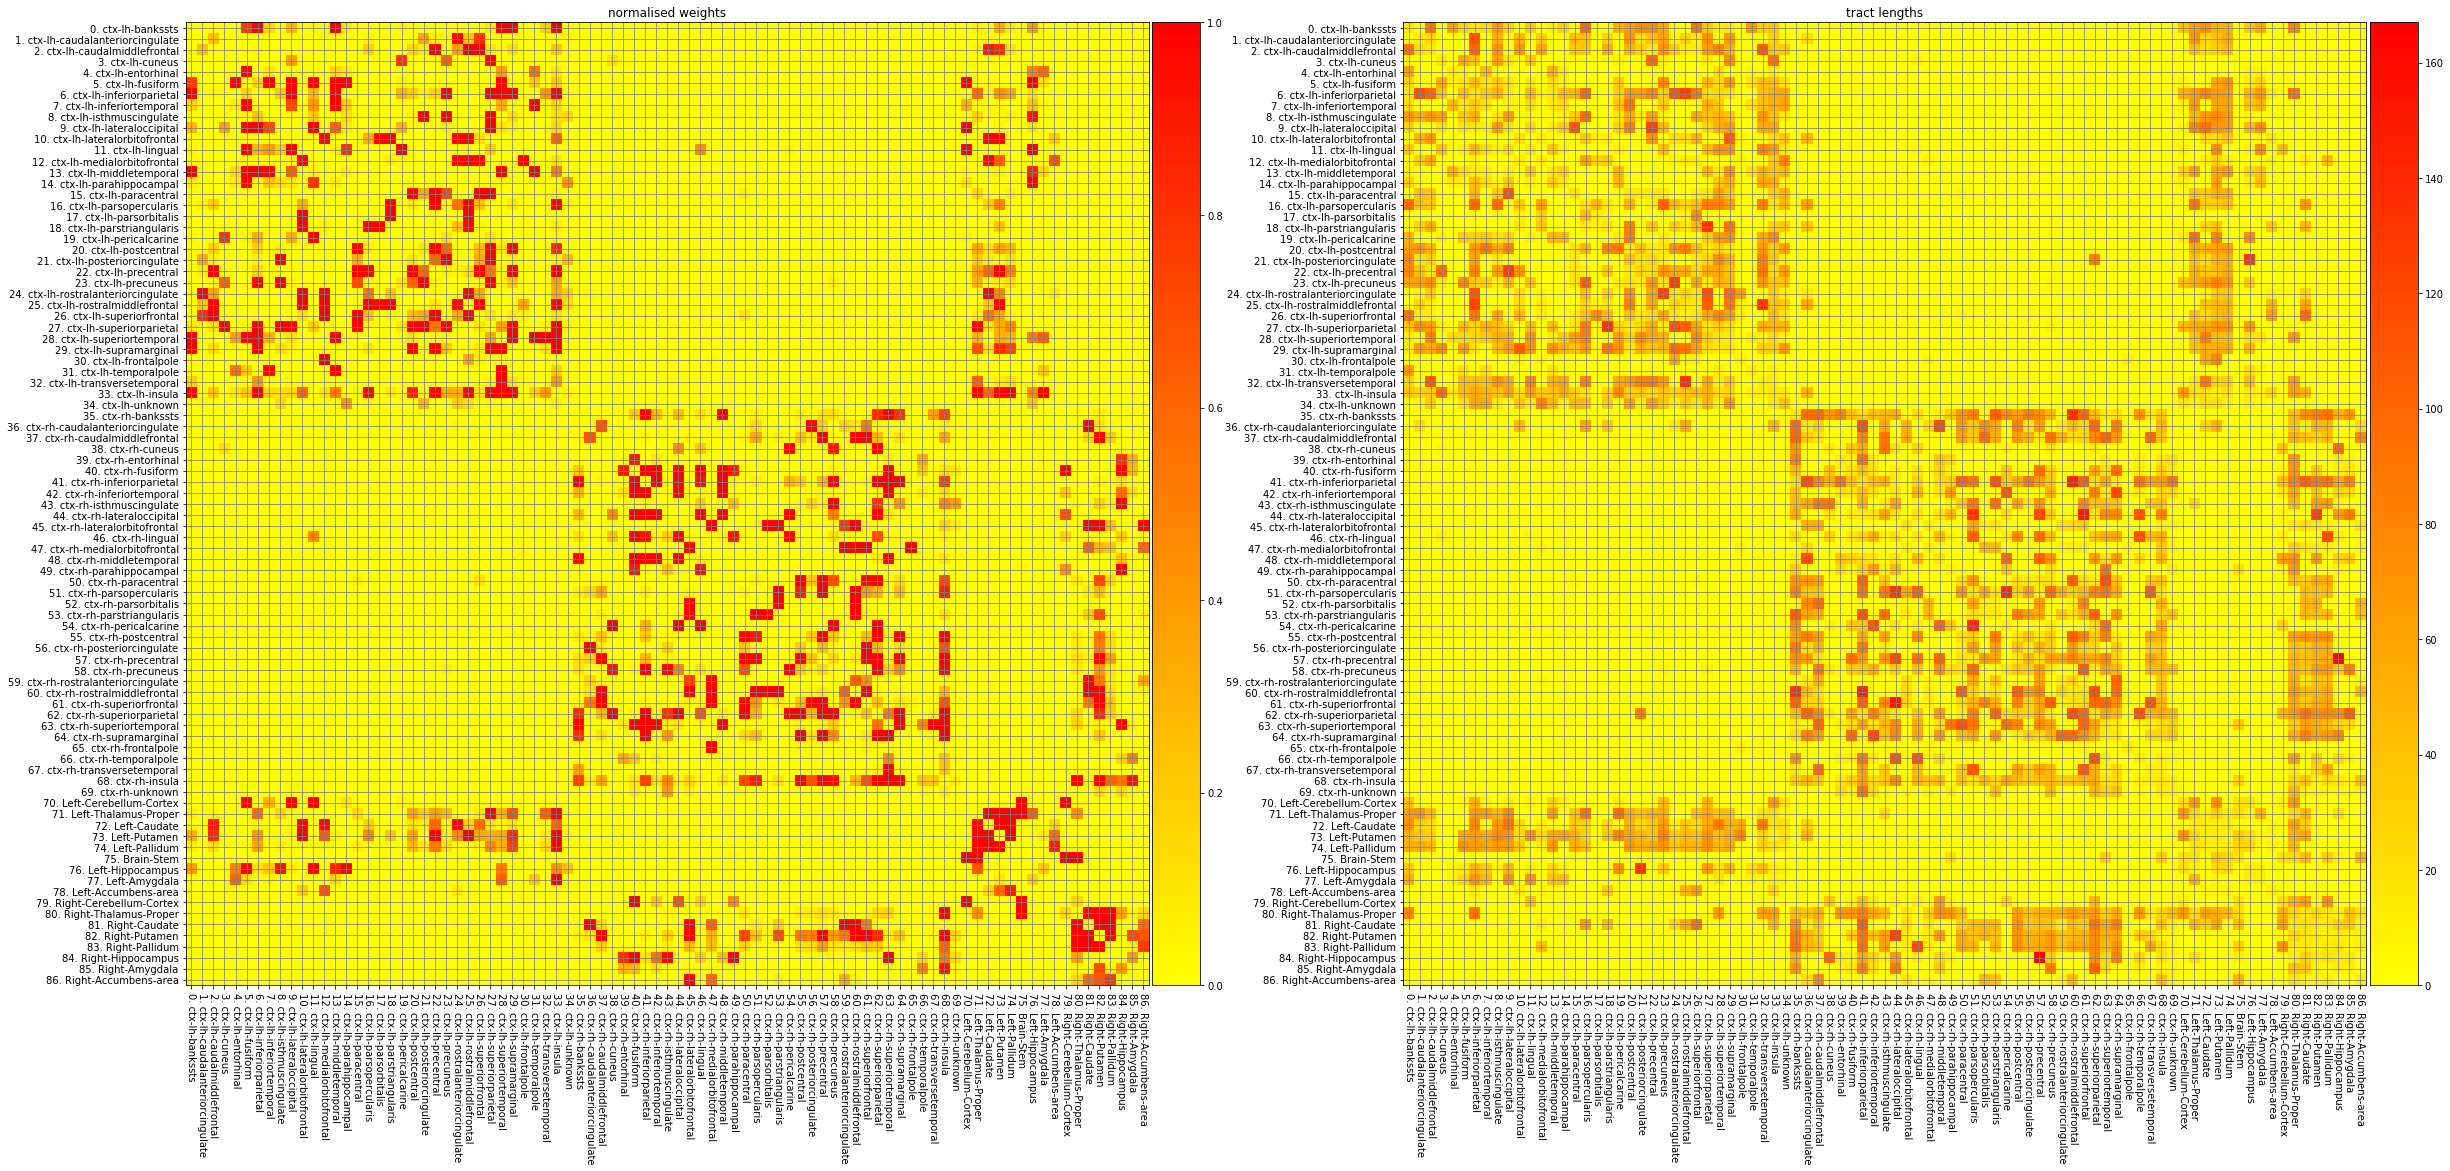

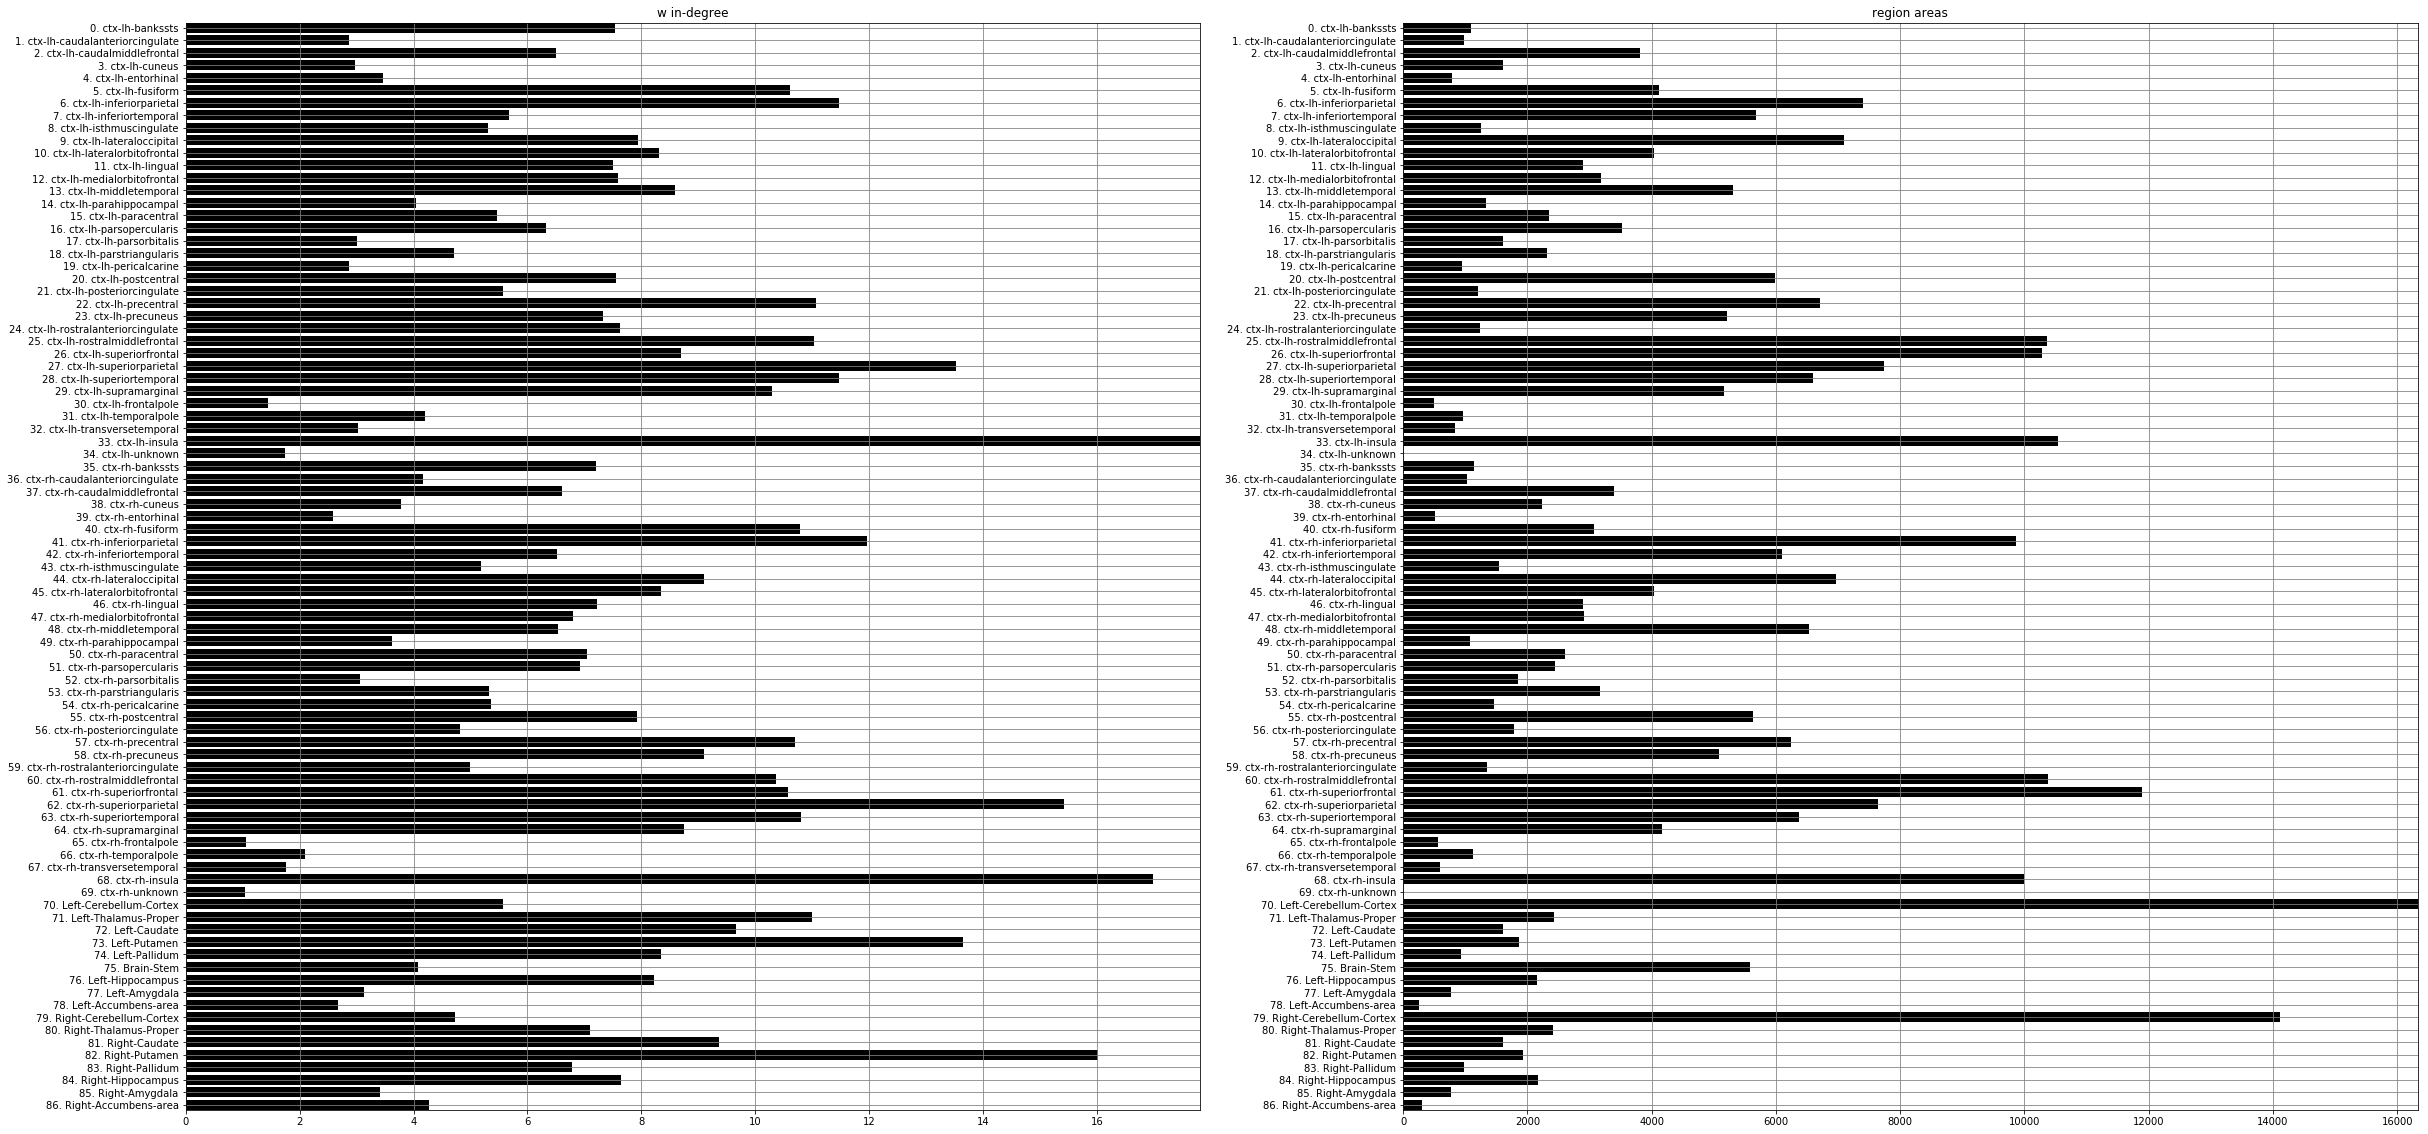

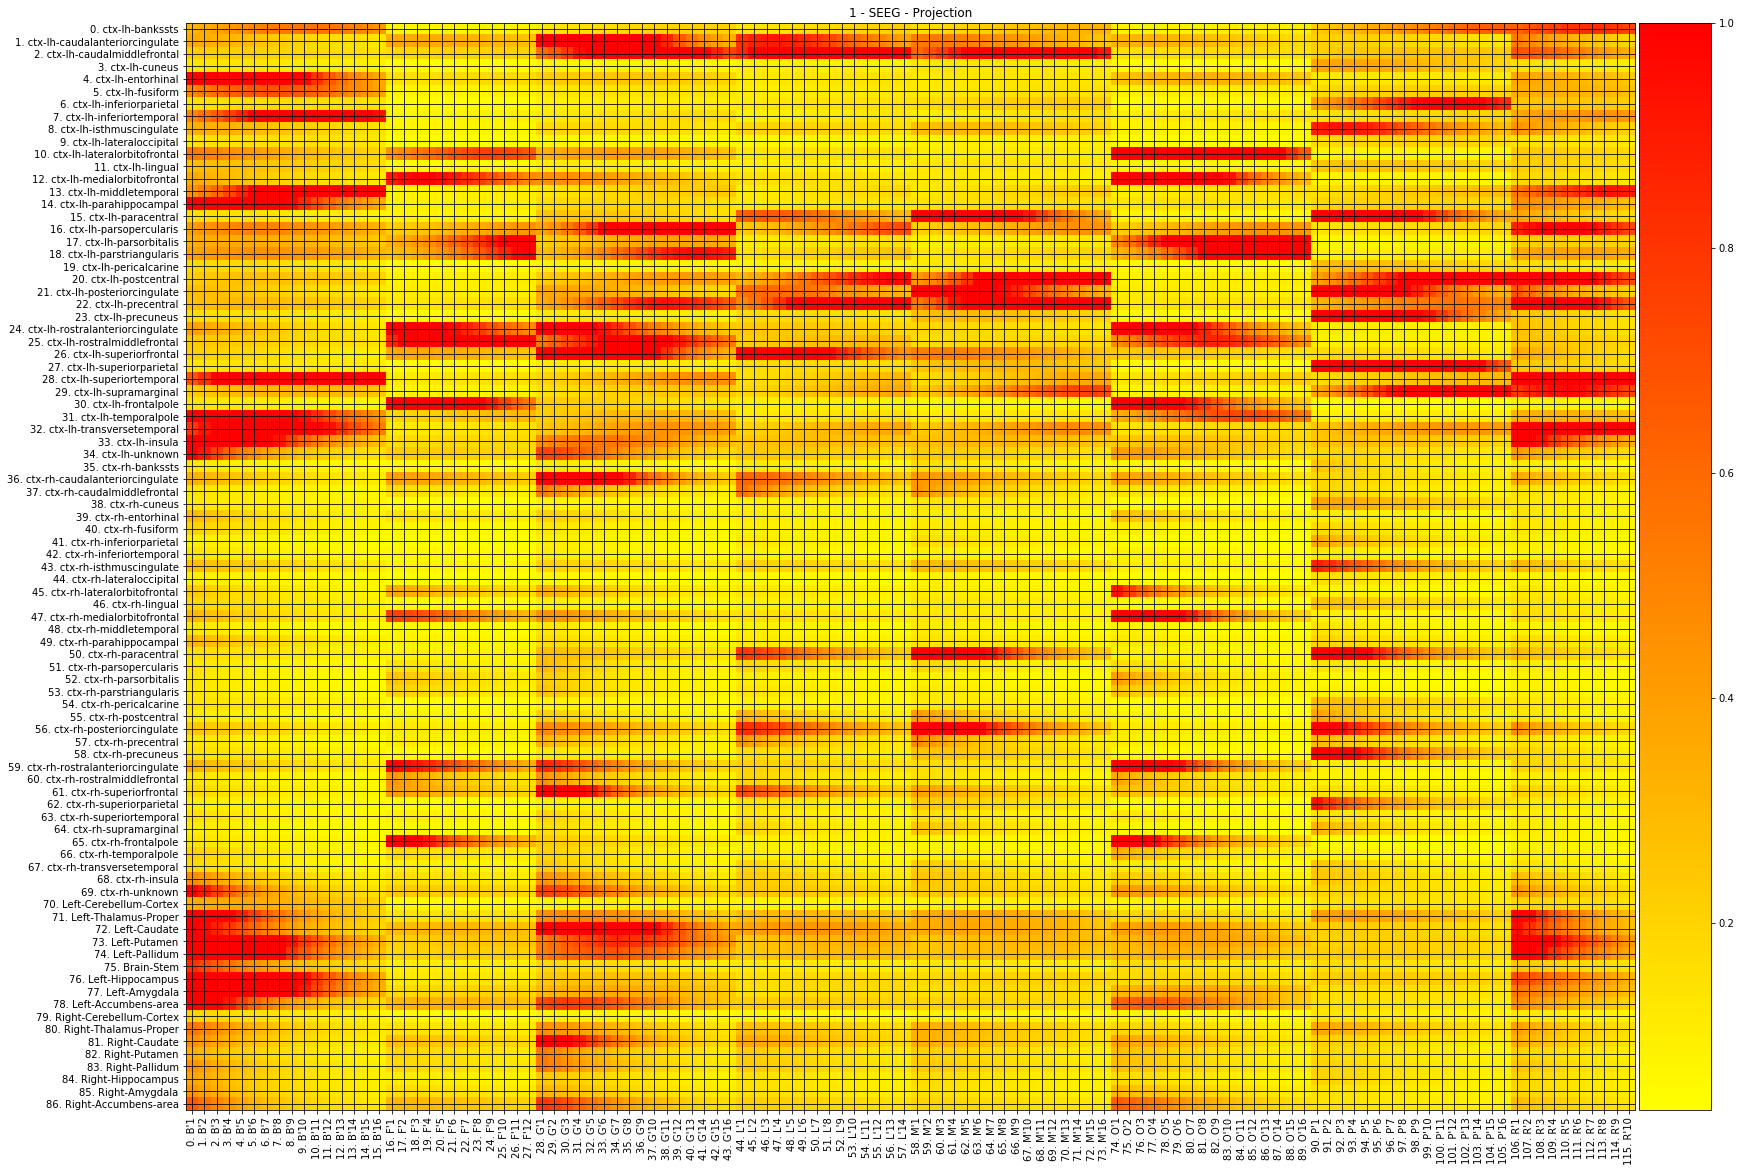

In [2]:
### Reading data
logger.info("Reading from: " + config.input.HEAD)
head = reader.read_head(config.input.HEAD, seeg_sensors_files=[("seeg_xyz.txt",)])
# Plot
plotter.plot_head(head)

### Generate an hypothesis by manual definition 

In [3]:
# logger.info("\n\Reading hypothesis from file...")        
# lsa_hypothesis = reader.read_hypothesis(hypothesis_file)

# Formulate a VEP hypothesis manually
from tvb_epilepsy.service.hypothesis_builder import HypothesisBuilder

hyp_builder = HypothesisBuilder(head.connectivity.number_of_regions, config)

# Regions of Pathological Excitability hypothesis:
x0_indices = [2, 24]
x0_values = [0.01, 0.01]
hyp_builder.set_x0_hypothesis(x0_indices, x0_values)

# Regions of Model Epileptogenicity hypothesis:
e_indices = [1, 26]
e_values = np.array([0.99, 0.99])
hyp_builder.set_e_hypothesis(e_indices, e_values)

# Regions of Connectivity hypothesis:
w_indices = [] # [(0, 1), (0, 2)] 
w_values = [] # [0.5, 2.0] 
# hypo_builder.set_w_indices(w_indices).set_w_values(w_values)

hypothesis = hyp_builder.set_normalize(0.99).build_hypothesis()

### ...or by reading from epileptogenicity file...

In [ ]:
from tvb_epilepsy.service.hypothesis_builder import HypothesisBuilder
# Read clinical hypothesis 
hyp_builder = HypothesisBuilder(head.connectivity.number_of_regions, config).set_normalize(0.99)
e_indices = [1, 26]# [1, 2, 25, 26]
hypothesis = hyp_builder.build_hypothesis_from_file("clinical_hypothesis_postseeg", e_indices) 
# Change something manually if necessary
hypothesis.x0_values = [0.01, 0.01]

### Print hypothesis

In [4]:
disease_indices = hypothesis.regions_disease_indices
disease_values = hypothesis.regions_disease_values
w_indices = hypothesis.connectivity_disease_indices
w_values = hypothesis.connectivity_disease_values
n_w = len(w_indices)
n_e = len(e_indices)
n_disease = len(disease_indices)
n_x0 = n_disease - n_e
all_regions_indices = np.array(range(head.number_of_regions))
healthy_indices = np.delete(all_regions_indices, disease_indices).tolist()
n_healthy = len(healthy_indices)
print(hypothesis)
print(hypothesis.string_regions_disease(head.connectivity.region_labels))
print(hypothesis.string_connectivity_disease(head.connectivity.region_labels))

DiseaseHypothesis{
01. Name = e_x0_Hypothesis
02. Type = Excitability_Epileptogenicity
03. Number of regions = 87
04. Excitability (x0) disease indices = [2, 24]
05. Excitability (x0) disease values = [0.01, 0.01]
06. Epileptogenicity (E) disease indices = [1, 26]
07. Epileptogenicity (E) disease values = [0.99, 0.99]
08. Connectivity (W) disease indices = []
09. Connectivity (W) disease values = []
10. Propagation indices = []
11. Propagation strengths of indices = []}
1. ctx-lh-caudalanteriorcingulate: E=0.99
2. ctx-lh-caudalmiddlefrontal: x0=0.01
24. ctx-lh-rostralanteriorcingulate: x0=0.01
26. ctx-lh-superiorfrontal: E=0.99



### Generate model configuration from hypothesis

1: E=0.99
2: x0=0.01
24: x0=0.01
26: E=0.99
K = 3.44828
x0_max = -0.313208386857
x0_min = -2.46018603389
x1eq_max = -1.33667
x1eq_min = -1.66626


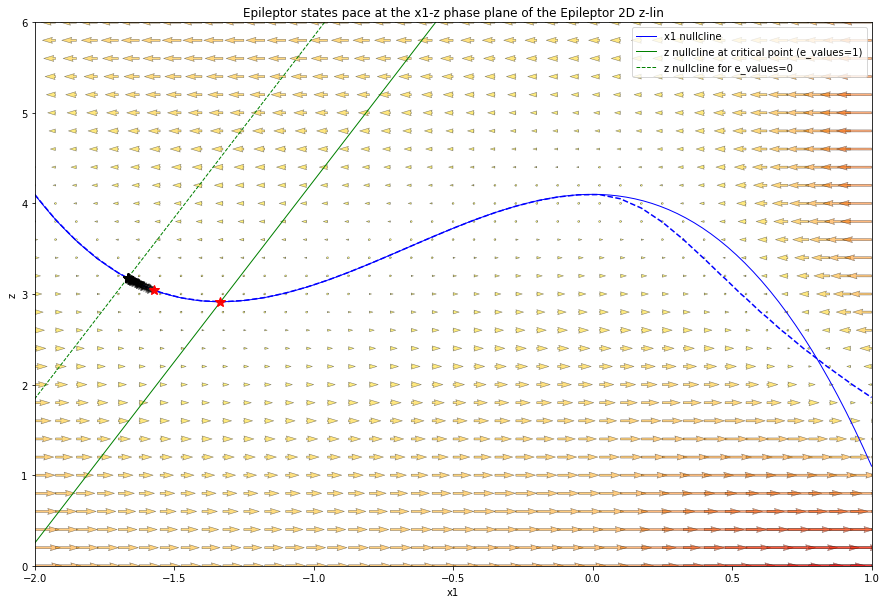

In [5]:
# logger.info("\n\nReading model configuration from file...")
# model_configuration = reader.read_model_configuration(model_config_file)

from tvb_epilepsy.service.model_configuration_builder import ModelConfigurationBuilder
from tvb_epilepsy.base.constants.model_constants import K_DEF

logger.info("\n\nRunning hypothesis: " + hypothesis.name)
logger.info("\n\nCreating model configuration...")
# K = 3*K_DEF # in the case of the above hypothesis read from file
K = 3*K_DEF #3! in the case of the above manual hypothesis
model_config_builder = ModelConfigurationBuilder(hypothesis.number_of_regions, K=K)
mcs_file = os.path.join(config.out.FOLDER_RES, hypothesis.name + "_model_config_service.h5")
writer.write_model_configuration_builder(model_config_builder, mcs_file)
print(hypothesis.string_regions_disease())
# Assume all healthy nodes have x0_values = 0.0:
model_configuration = model_config_builder.build_model_from_hypothesis(hypothesis, head.connectivity.normalized_weights)
# # Assume all healthy nodes have e_values = 0.0
# model_configuration = model_config_builder.build_model_from_E_hypothesis(hypothesis, head.connectivity.normalized_weights)
print "K =", np.mean(model_configuration.K)
print "x0_max =", np.max(model_configuration.x0)
print "x0_min =", np.min(model_configuration.x0)
print "x1eq_max =", np.max(model_configuration.x1eq)
print "x1eq_min =", np.min(model_configuration.x1eq)
mc_path = os.path.join(config.out.FOLDER_RES, hypothesis.name + "_ModelConfig.h5")
writer.write_model_configuration(model_configuration, mc_path)
# Plot nullclines and equilibria of model configuration
plotter.plot_state_space(model_configuration, "2D", head.connectivity.region_labels, 
                         special_idx=hypothesis.regions_disease_indices, 
                         figure_name=hypothesis.name + "_StateSpace")

# LINEAR STABILITY ANALYSIS

### Run linear stability analysis

DiseaseHypothesis{
01. Name = e_x0_Hypothesis_LSA
02. Type = Excitability_Epileptogenicity
03. Number of regions = 87
04. Excitability (x0) disease indices = [2, 24]
05. Excitability (x0) disease values = [0.01, 0.01]
06. Epileptogenicity (E) disease indices = [1, 26]
07. Epileptogenicity (E) disease values = [0.99, 0.99]
08. Connectivity (W) disease indices = []
09. Connectivity (W) disease values = []
10. Propagation indices = [ 1 26]
11. Propagation strengths of indices = [ 0.17032836  0.72853272]}


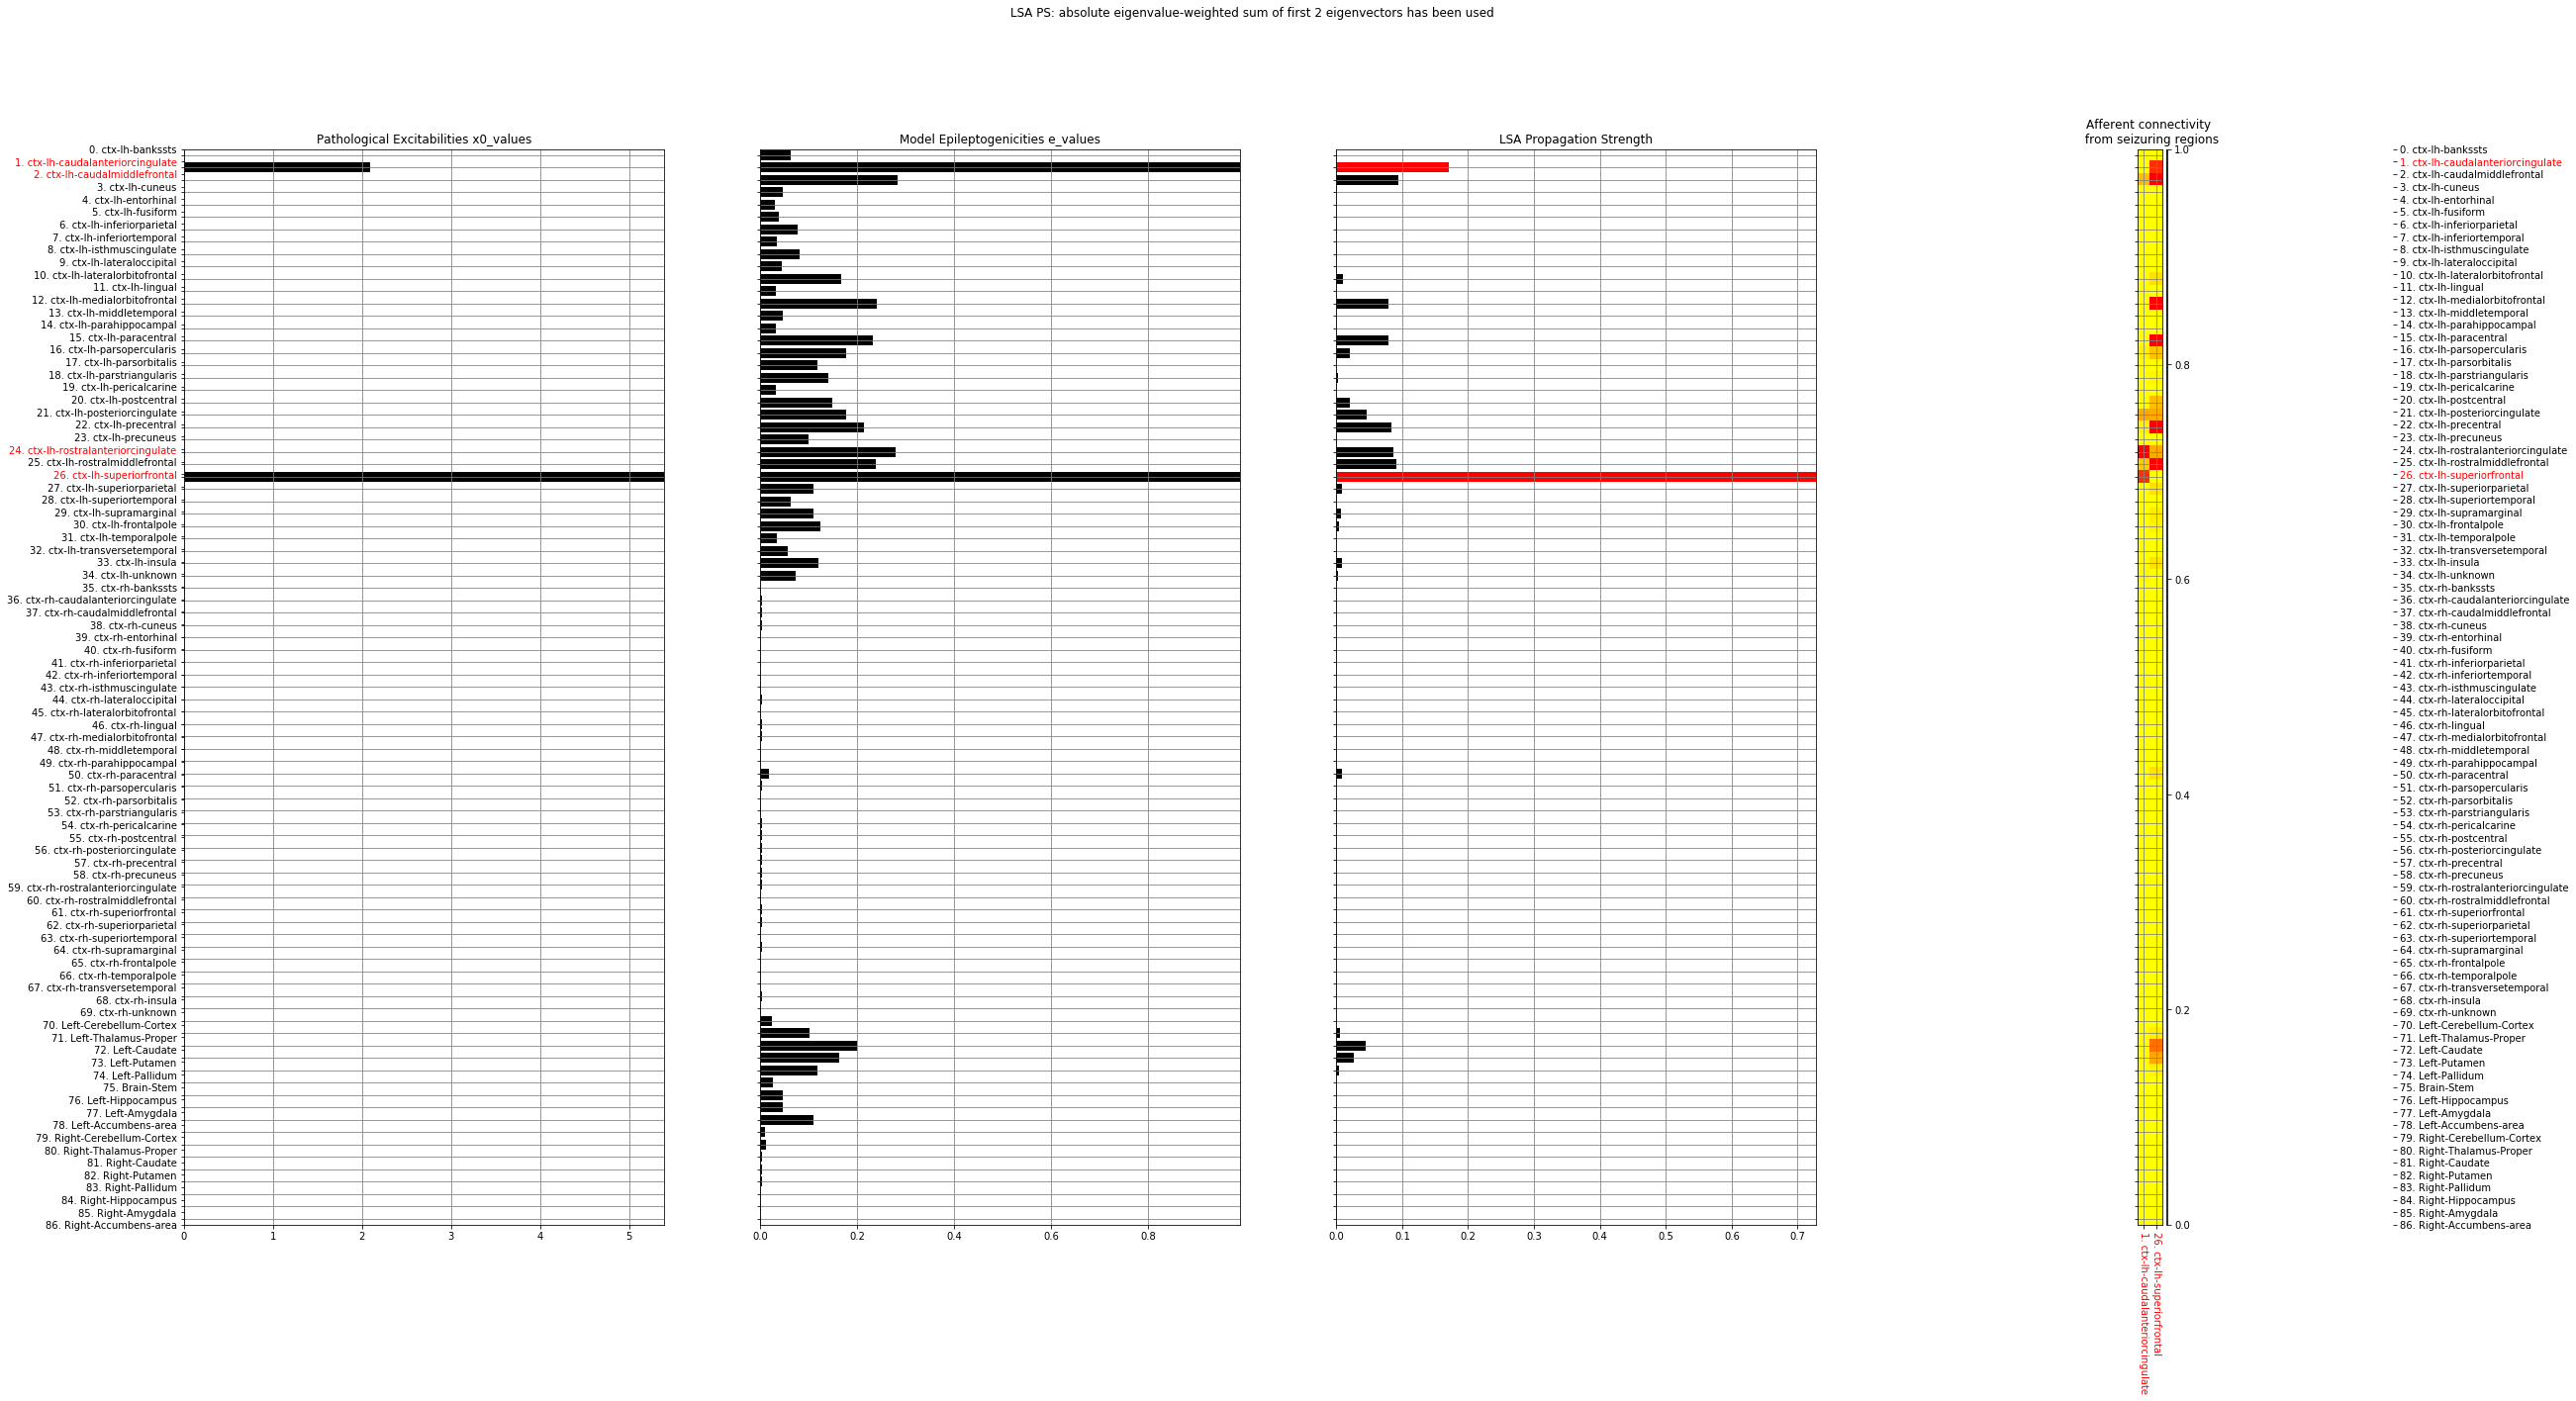

In [6]:
# Run linear stability analysis
# logger.info("\n\Reading LSA hypothesis from file...")        
# lsa_hypothesis = reader.read_hypothesis(lsa_hypothesis_file)
from tvb_epilepsy.service.lsa_service import LSAService
logger.info("\n\nRunning LSA...")
# Options for eigen_vectors_number: 
# "auto_eigenvals": eigenvalues curve elbow point selection,
# "auto_disease": len(n_disease), 
# "auto_epileptogenicity": Model Epileptogenicity curve elbow point selection,
# "auto_excitability": Pathological Excitability curve elbow point selection
# or "user_defined": a number equal to from 1 to hypothesis.number_of_regions
lsa_service = LSAService(eigen_vectors_number=None, 
                         eigen_vectors_number_selection="auto_eigenvals", 
                         weighted_eigenvector_sum=True, 
                         normalize_propagation_strength=False)
lsa_hypothesis = lsa_service.run_lsa(hypothesis, model_configuration)
print(lsa_hypothesis)
lsa_path = os.path.join(config.out.FOLDER_RES, lsa_hypothesis.name + "_LSA.h5")
lsa_config_path = os.path.join(config.out.FOLDER_RES, lsa_hypothesis.name + "_LSAConfig.h5")
writer.write_hypothesis(lsa_hypothesis, lsa_path)

# Plot
plotter.plot_lsa(lsa_hypothesis, model_configuration, lsa_service.weighted_eigenvector_sum,
                 lsa_service.eigen_vectors_number, head.connectivity.region_labels, None);


### Run parameter search exploration for linear stability analysis around the clinical hypothesis

2018-05-31 16:57:59,601 - WARNING - tvb_epilepsy.service.sampling.probabilistic_sampling_service - Input parameters' size (1) larger than the one implied by input parameters's shape (83)!
Modifying input parameters' size accordingly!

Generated a parameter search exploration for lsa/sim task,
with 88 parameters of 100 values each,
leading to 100 total execution loops

Executing loop 1 of 100

Executing loop 10 of 100

Executing loop 20 of 100

Executing loop 30 of 100

Executing loop 40 of 100

Executing loop 50 of 100

Executing loop 60 of 100

Executing loop 70 of 100

Executing loop 80 of 100

Executing loop 90 of 100

Executing loop 100 of 100


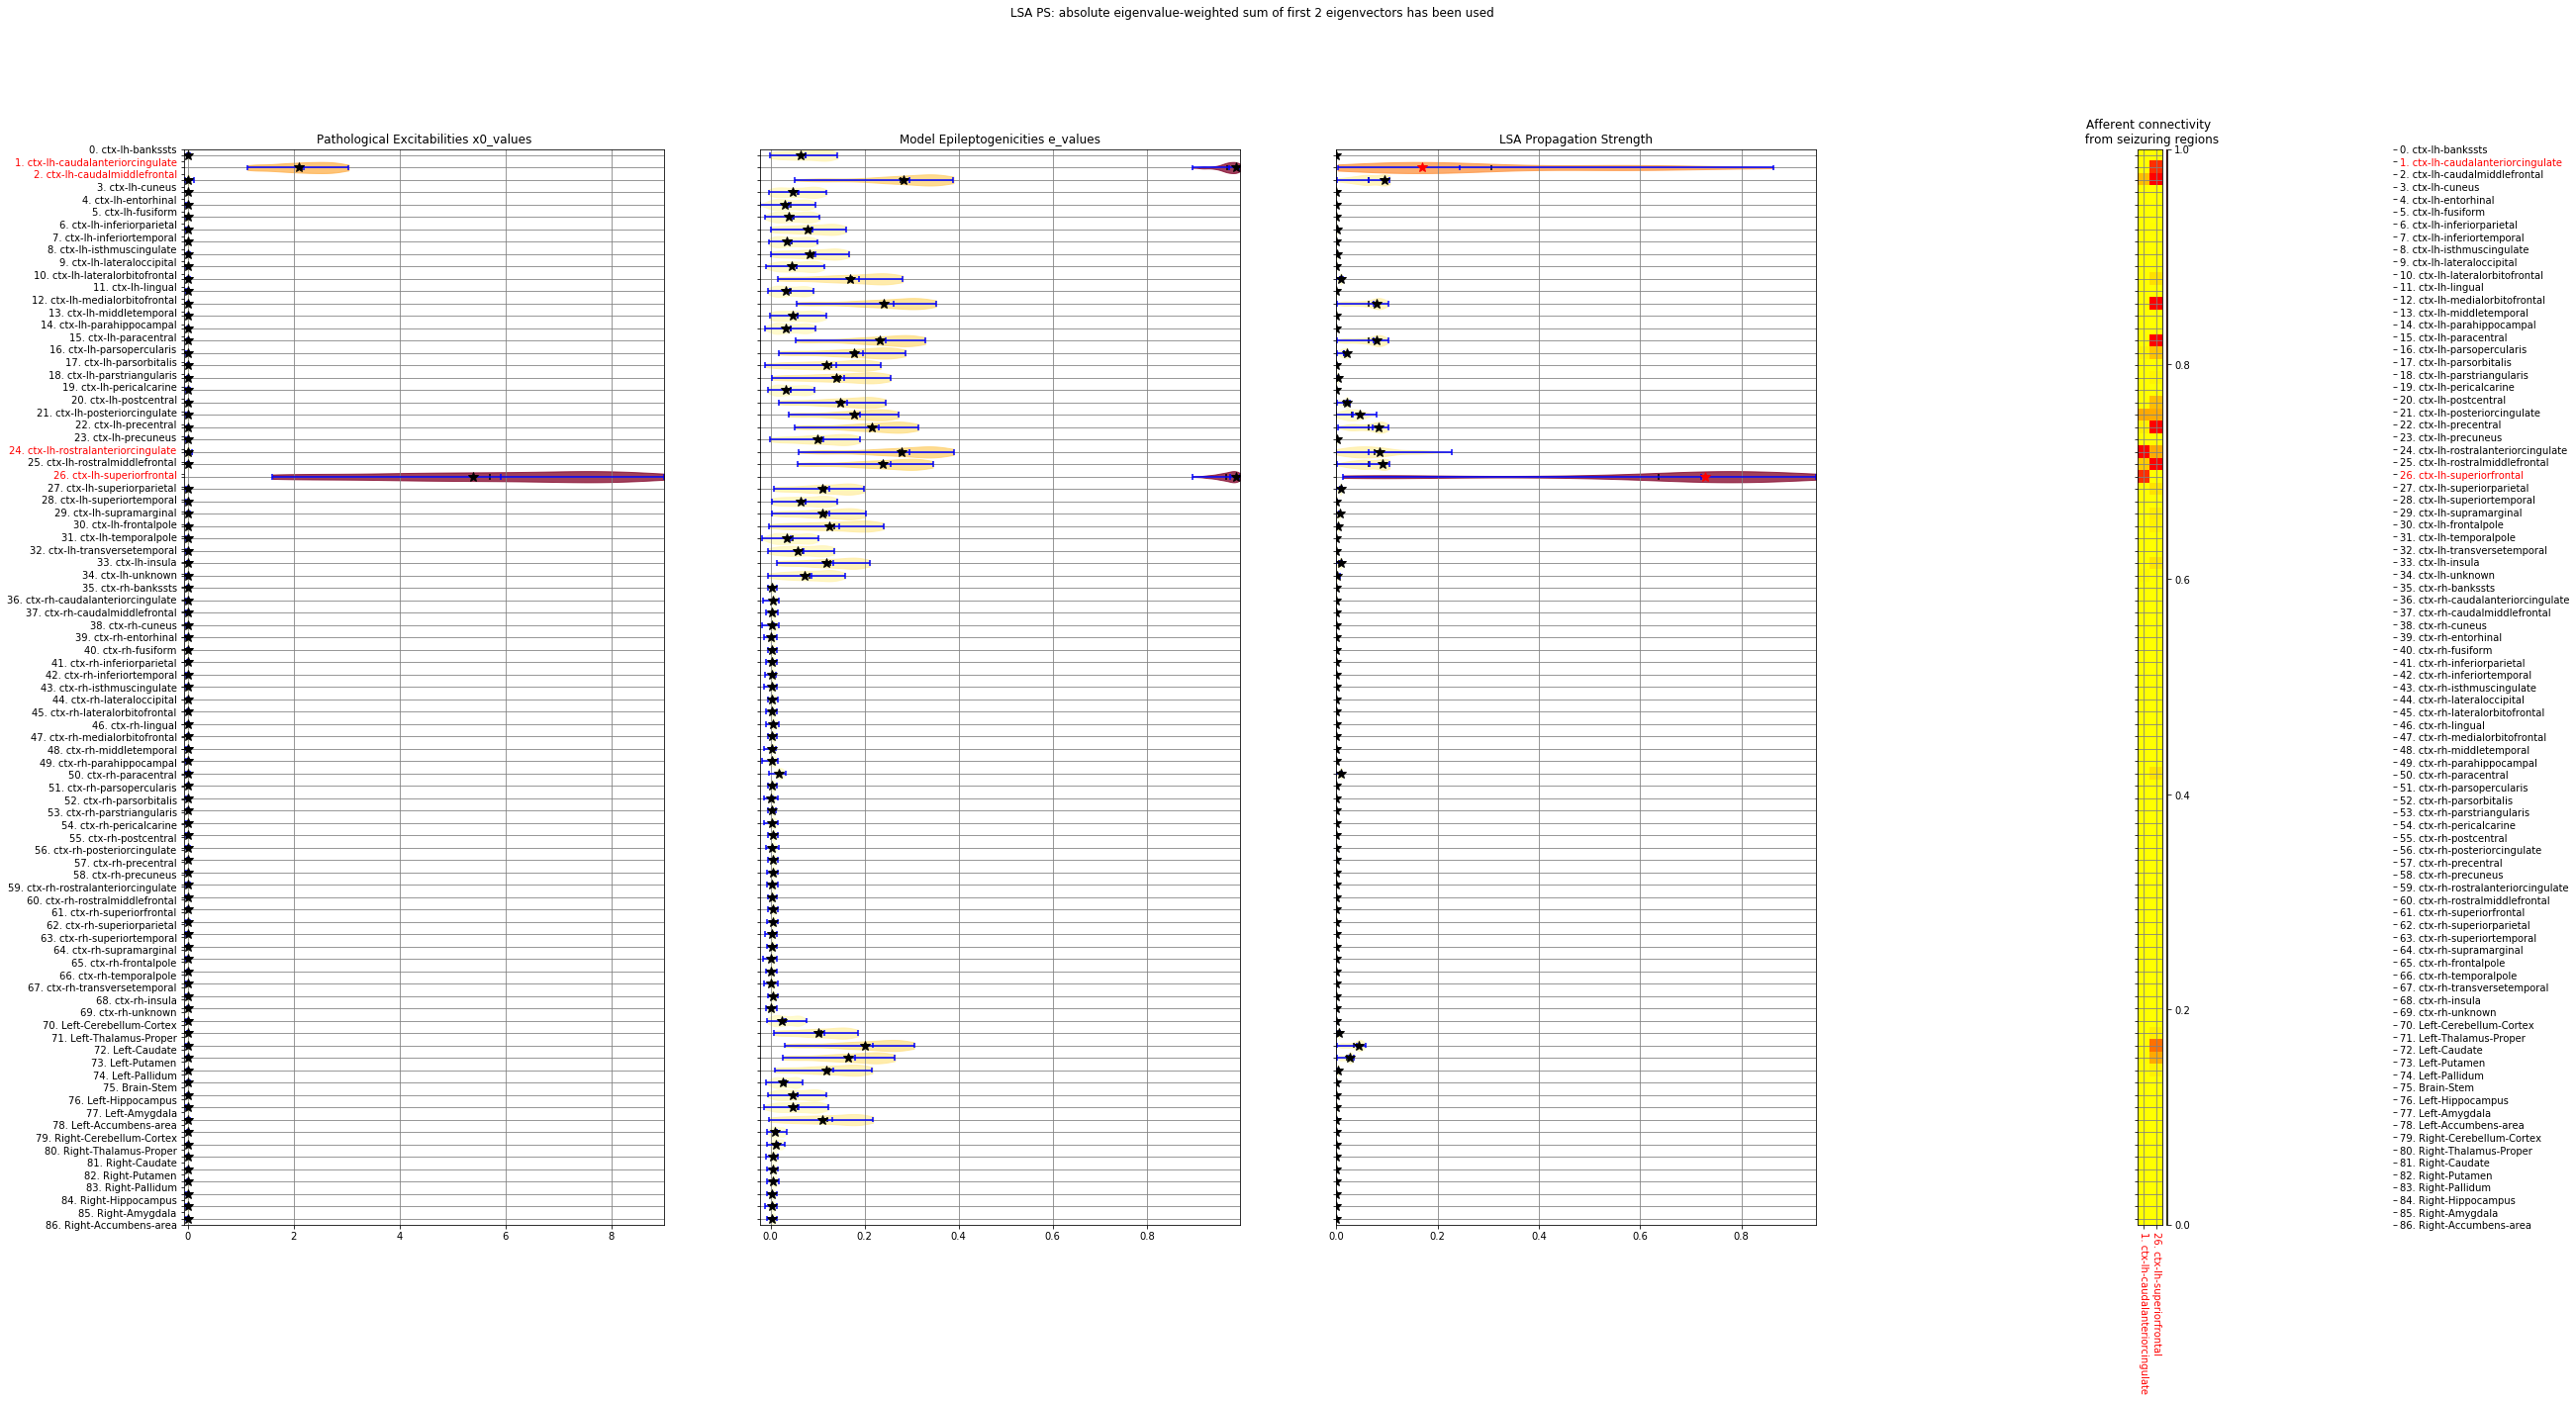

In [7]:
from tvb_epilepsy.top.scripts.pse_scripts import pse_from_lsa_hypothesis
# --------------Parameter Search Exploration (PSE)-------------------------------
logger.info("\n\nRunning PSE LSA...")
n_samples = 100
pse_results = pse_from_lsa_hypothesis(n_samples, lsa_hypothesis, 
                                      head.connectivity.normalized_weights,
                                      model_config_builder, lsa_service,
                                      head.connectivity.region_labels,
                                      param_range=0.1,
                                      global_coupling=[{"indices": all_regions_indices}],
                                      healthy_regions_parameters=[
                                                        {"name": "x0_values", "indices": healthy_indices}],
                                      logger=logger, save_flag=False)[0]
plotter.plot_lsa(lsa_hypothesis, model_configuration, lsa_service.weighted_eigenvector_sum,
                 lsa_service.eigen_vectors_number, head.connectivity.region_labels, pse_results)

writer.write_dictionary(pse_results, os.path.join(config.out.FOLDER_RES, hypothesis.name + "_PSE_LSA_results.h5"))

# SIMULATION

### Prepare simulation

In [12]:
from collections import OrderedDict
from tvb_epilepsy.base.model.timeseries import Timeseries, TimeseriesDimensions
from tvb_epilepsy.service.simulator.simulator_builder import SimulatorBuilder
from tvb_epilepsy.top.scripts.simulation_scripts import compute_seeg_and_write_ts_to_h5

# --------------------------Simulation-----------------------------------
sim_type = "fitting" # "realistic" # "tvb" # "reduced" #"fitting"
logger.info("\n\nConfiguring simulation from model_configuration...")
# If you choose model...
# Available models beyond the TVB Epileptor (they all encompass optional variations from the different papers):
# EpileptorDP: similar to the TVB Epileptor + optional variations,
# EpileptorDP2D: reduced 2D model, following Proix et all 2014 +optional variations,
# EpleptorDPrealistic: starting from the TVB Epileptor + optional variations, but:
#      -x0, Iext1, Iext2, slope and K become noisy state variables,
#      -Iext2 and |slope are coupled to z, g, or z*g in order for spikes to appear before seizure,
#      -multiplicative correlated noise is also used
# We don't want any time delays for the moment
head.connectivity.tract_lengths *= 0.0
sim_builder = SimulatorBuilder(config.simulator.MODE)
# sim_settings = reader.read_simulation_settings(sim_settings_file)
# First set model name, then build settings!
report_every_n_monitor_step=100
if sim_type == "realistic":
    model = sim_builder.set_model_name("EpileptorDPrealistic").generate_model_tvb(model_configuration)
    model.tau0 = 30000.0
    model.tau1 = 0.2
    model.slope = 0.25
    sim_settings = sim_builder.set_simulated_period(30000).build_sim_settings()
    from tvb_epilepsy.base.constants.model_constants import COLORED_NOISE
    sim_settings.noise_type = COLORED_NOISE
    sim_settings.noise_ntau = 10
    report_every_n_monitor_step=1000
elif sim_type == "fitting":
    model = sim_builder.set_model_name("EpileptorDP2D").generate_model_tvb(model_configuration)
    model.tau0 = 30.0
    model.tau1 = 0.5
    sim_settings = sim_builder.set_fs(2048.0).set_fs_monitor(2048.0).set_simulated_period(300).build_sim_settings()
    sim_settings.noise_intensity = [0.0, 1e-5]
elif sim_type == "reduced":
    model = sim_builder.set_model_name("EpileptorDP2D").generate_model_tvb(model_configuration)
    model.tau0 = 2857.0
    model.tau1 = 0.5
    sim_settings = sim_builder.set_fs(2048.0).set_simulated_period(10000).build_sim_settings()
    sim_settings.noise_intensity = [0.0, 1e-7]
elif sim_type == "tvb":
   model = sim_builder.set_model_name("Epileptor").generate_model_tvb(model_configuration)
   sim_settings = sim_builder.set_simulated_period(5000).build_sim_settings()
else:
   model = sim_builder.generate_model_tvb(model_configuration)
   sim_settings = sim_builder.build_sim_settings()  # "EpileptorDP" by default

sim, sim_settings, model = sim_builder.build_simulator_TVB_from_model_sim_settings(model_configuration, 
                                                                                   head.connectivity, model, sim_settings)

writer.write_simulation_settings(sim.simulation_settings, os.path.join(config.out.FOLDER_RES, 
                                                                       hypothesis.name + "_SimSettings.h5"))
writer.write_generic(model, os.path.join(config.out.FOLDER_RES, hypothesis.name + "_" + 
                                             model._ui_name + "_SimModel.h5"))


### SIMULATE!

...100.09765625% done in 1.1675798893 secs

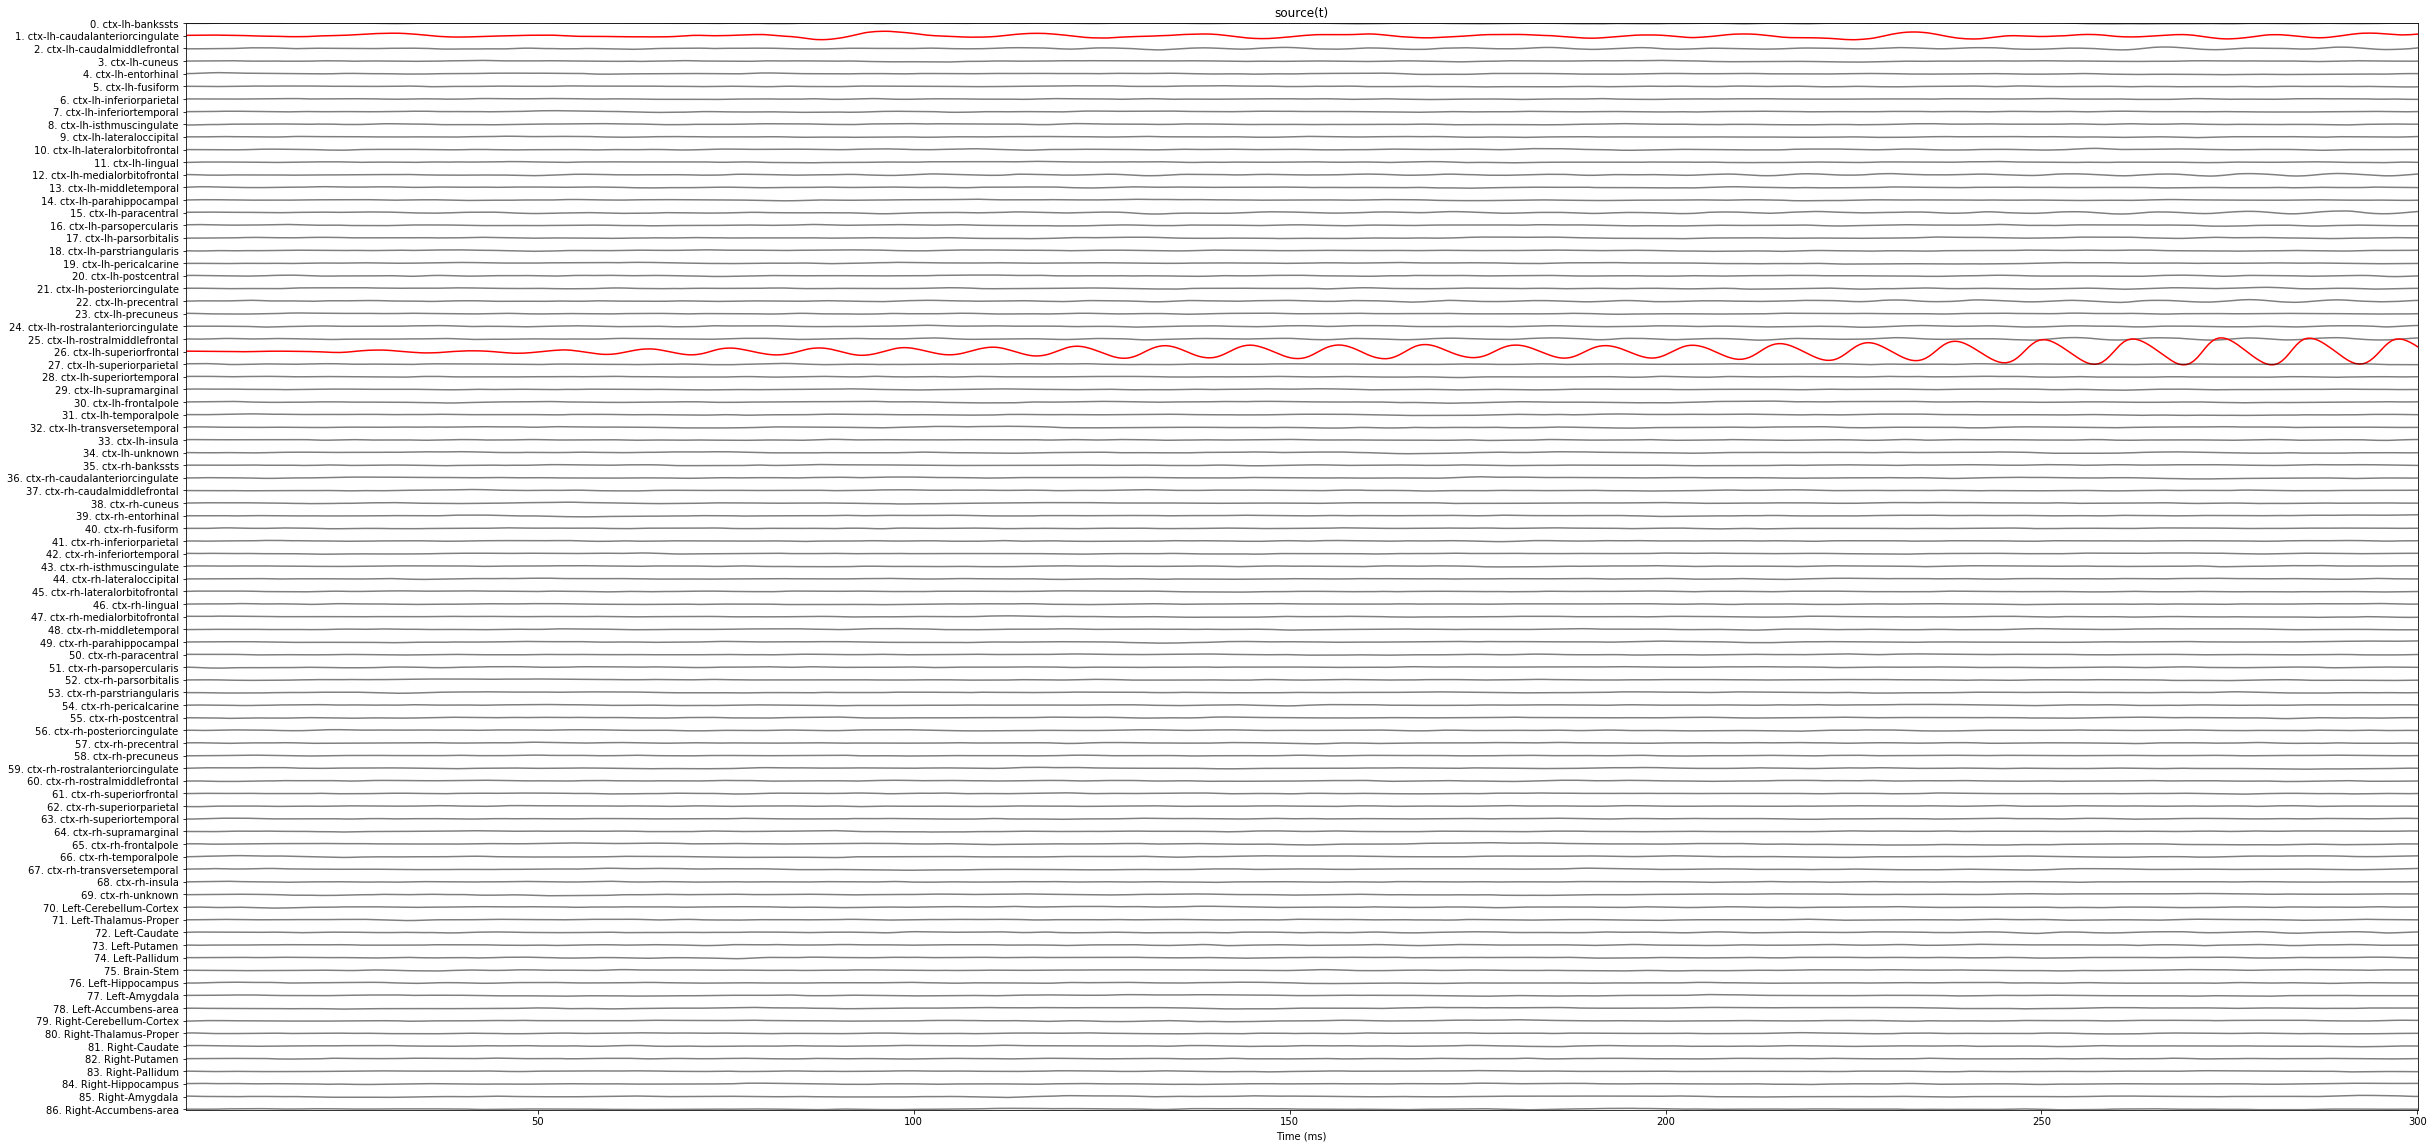

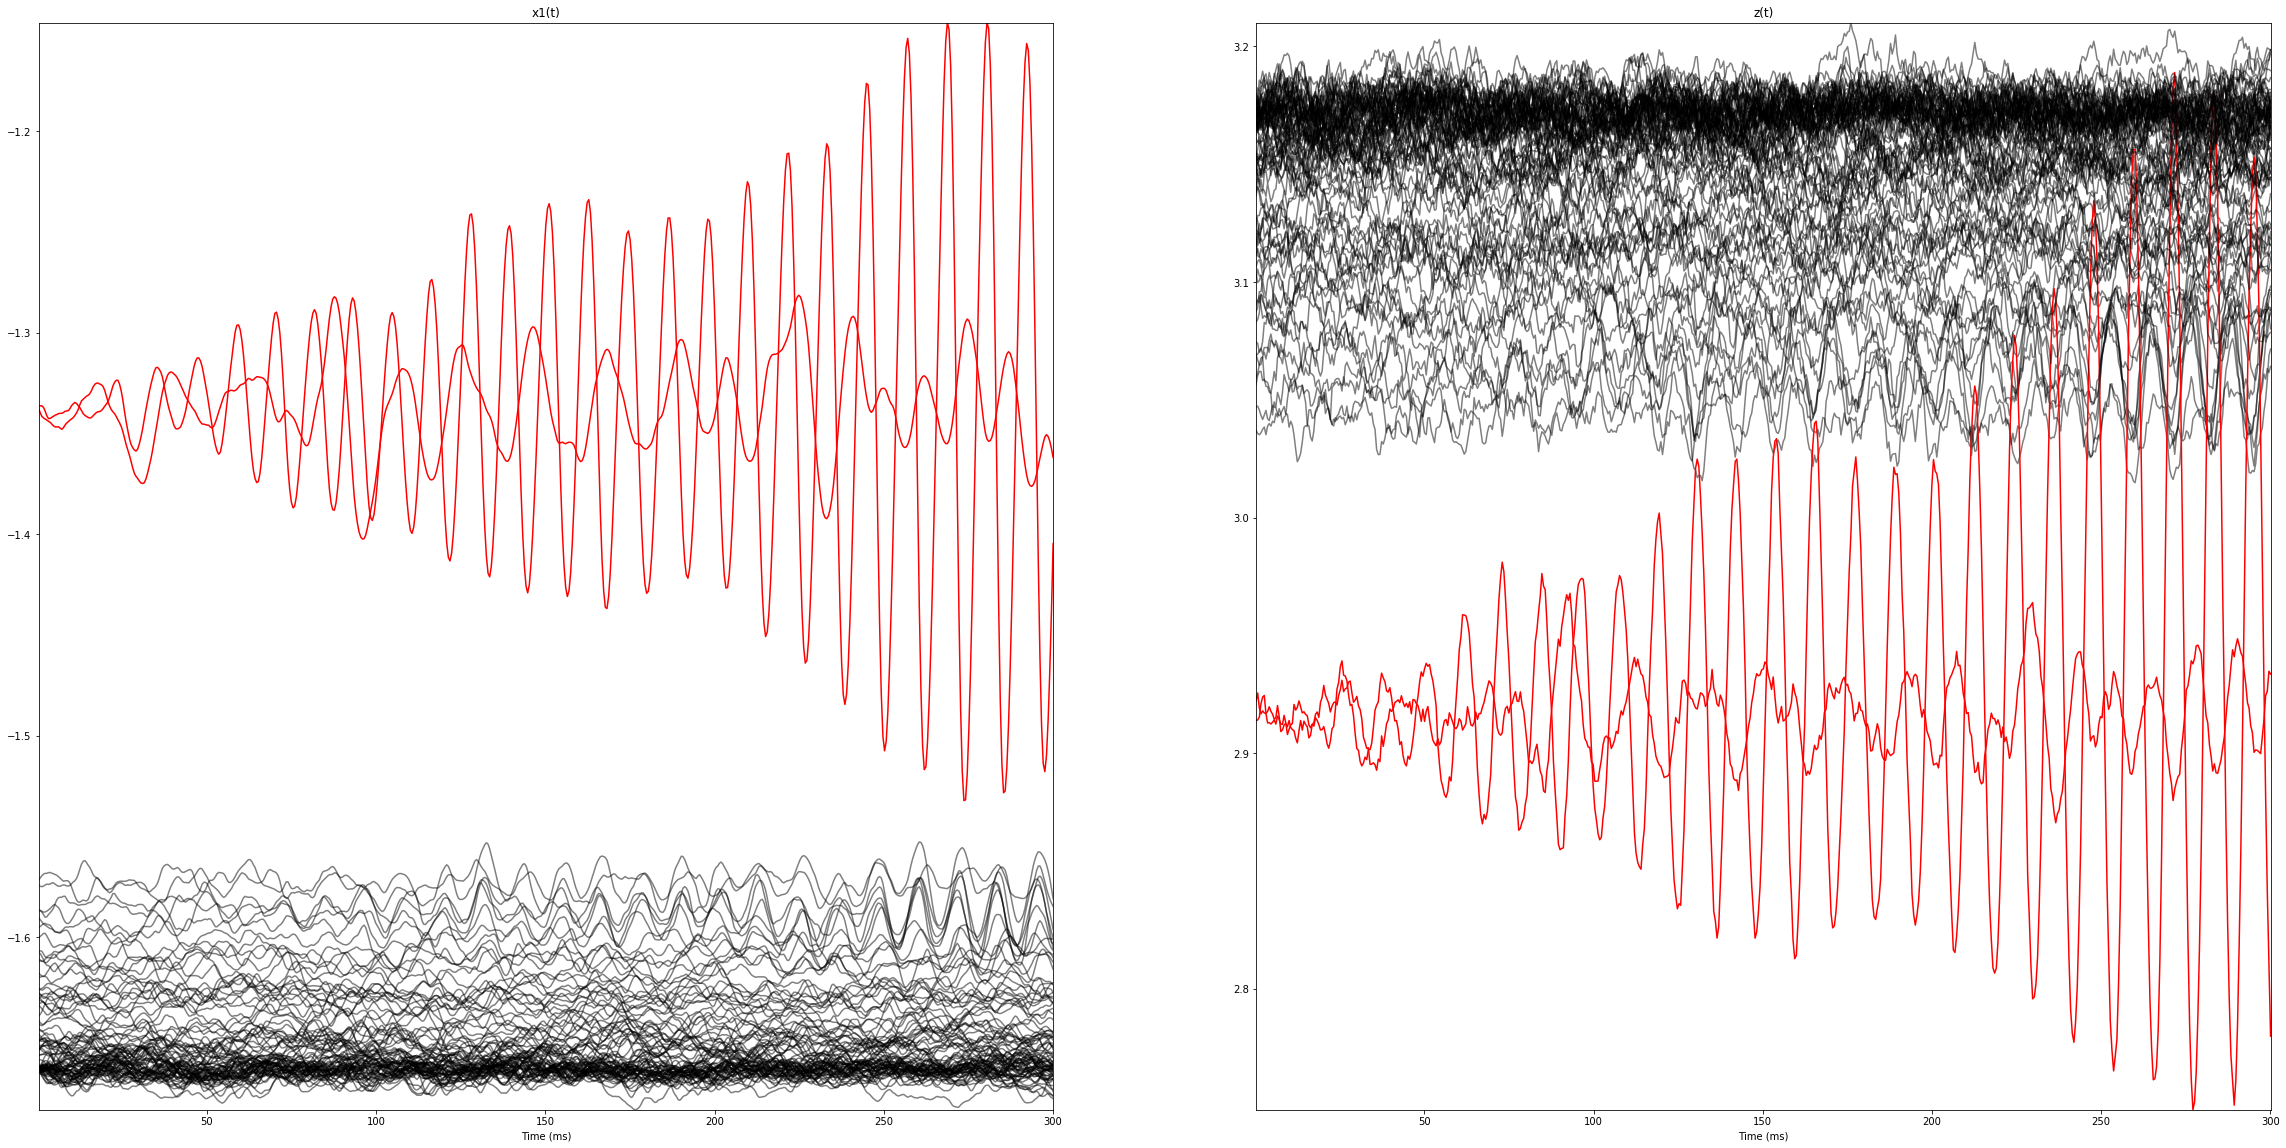

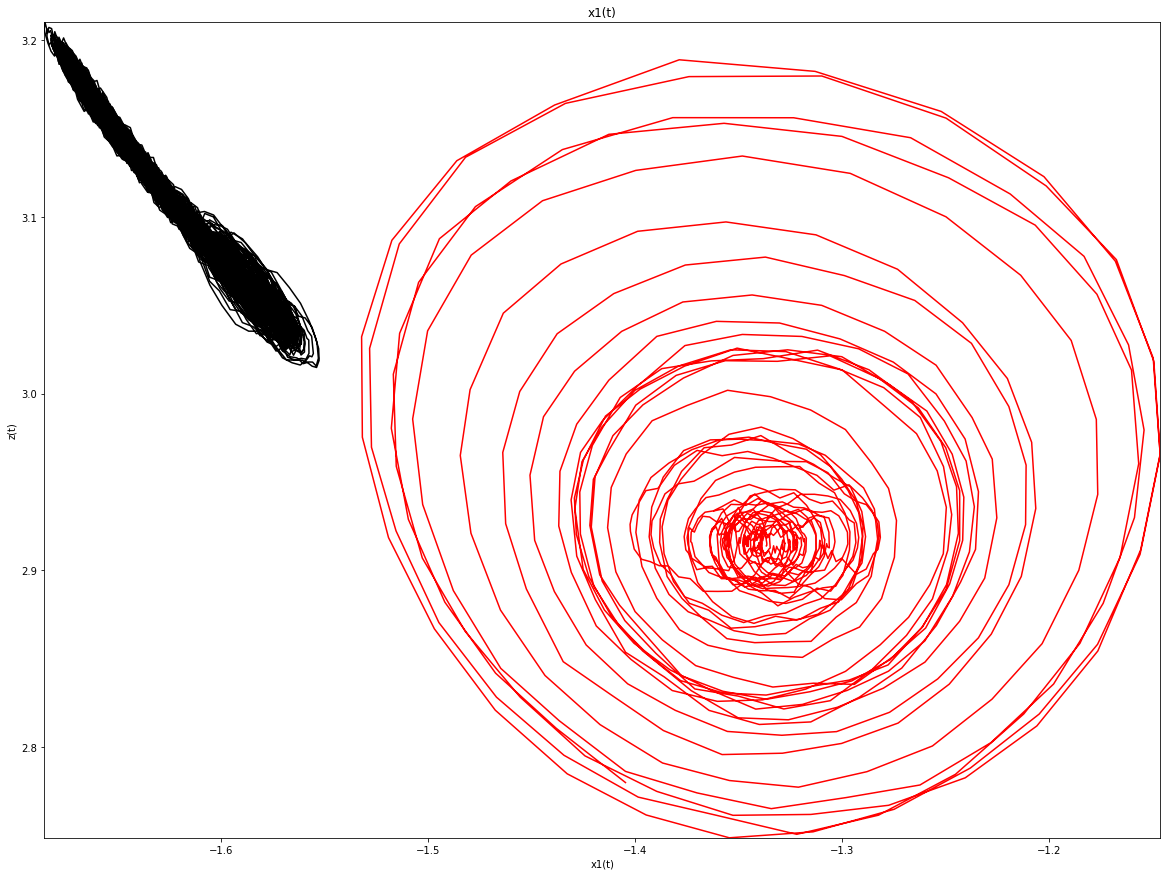

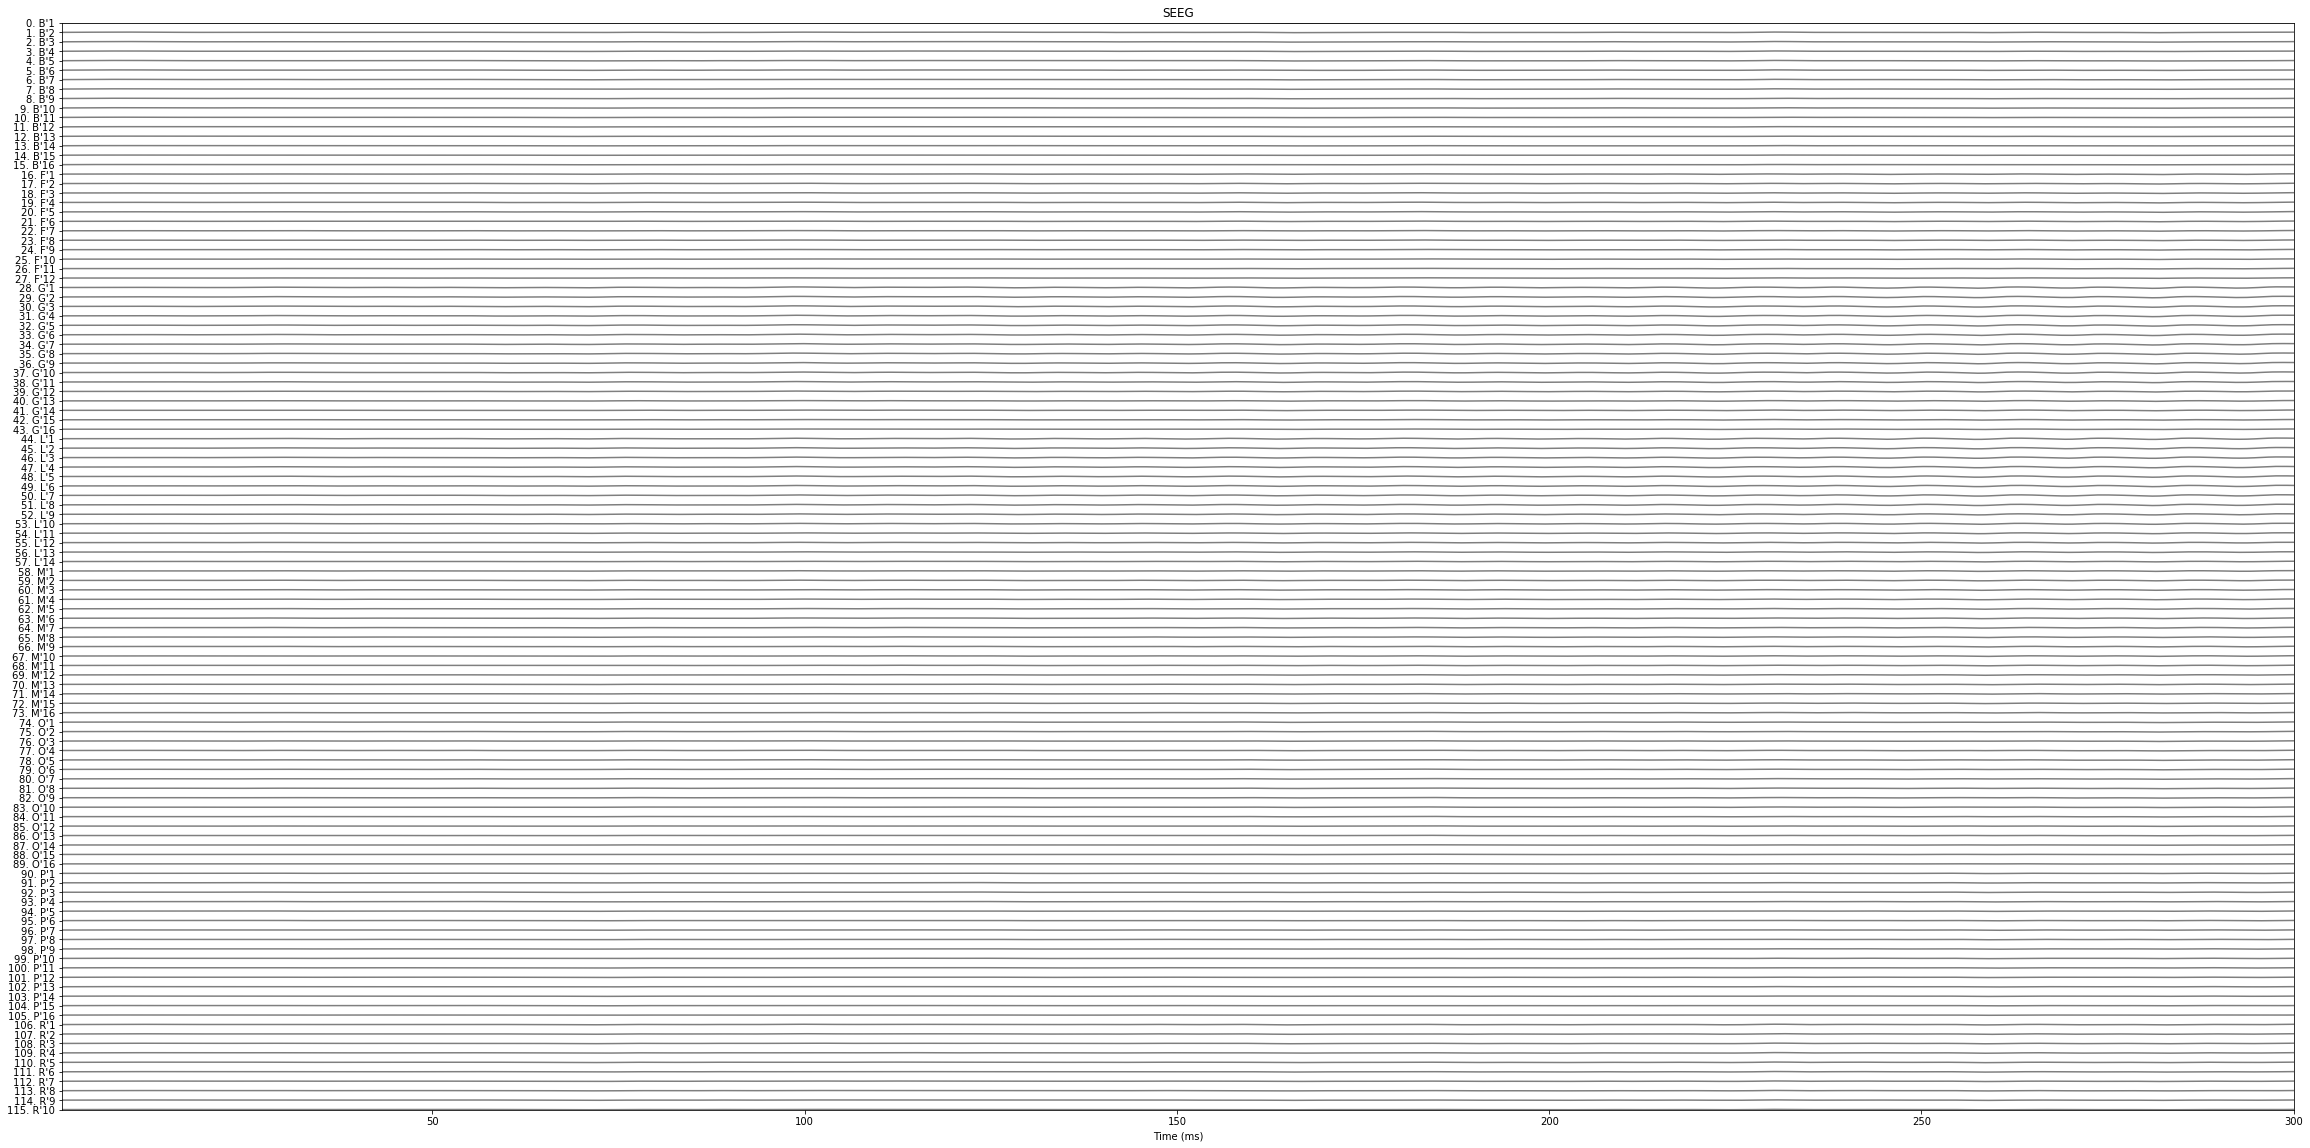

615


In [13]:
# Integrator and initial conditions initialization.
# By default initial condition is set right on the equilibrium point.
logger.info("\n\nSimulating...")
sim_output = []
seeg=[]
sim_output, status = sim.launch_simulation(report_every_n_monitor_steps=100)
sim_ts_file =  os.path.join(config.out.FOLDER_RES, hypothesis.name + sim.model._ui_name + "_ts.h5")
if not status:
    logger.warning("\nSimulation failed!")
else:
    sim_output, seeg = \
        compute_seeg_and_write_ts_to_h5(sim_output, sim.model, head.sensorsSEEG, sim_ts_file,
                                        seeg_gain_mode="lin", hpf_flag=True, hpf_low=10.0, hpf_high=512.0)
     
    # Plot results 
    plotter.plot_simulated_timeseries(sim_output, sim.model, lsa_hypothesis.lsa_propagation_indices, 
                                      seeg_list=seeg, spectral_raster_plot=False, log_scale=True, title_prefix=hypothesis.name)
print(sim_output.time_length)

# FITTING

### Basic configurations

In [14]:
from tvb_epilepsy.base.constants.model_inversion_constants import *
from tvb_epilepsy.top.scripts.fitting_scripts import *

# TVB3 larger preselection of sensors:
sensors_lbls = [u"B'1", u"B'2", u"B'3", u"B'4",
                u"F'1", u"F'2", u"F'3", u"F'4", u"F'5", u"F'6", 
                    u"F'7", u"F'8", u"F'9", u"F'10", u"F'11",
                u"G'1", u"G'2", u"G'3", u"G'4", u"G'8", u"G'9", u"G'10", 
                    u"G'11", u"G'12", u"G'13", u"G'14", u"G'15",
                u"L'1", u"L'2", u"L'3", u"L'4", u"L'5", u"L'6", u"L'7",
                    u"L'8", u"L'9", u"L'10", u"L'11", u"L'12", u"L'13",
                u"M'1", u"M'2", u"M'3", u"M'7", u"M'8", u"M'9", u"M'10", 
                    u"M'11", u"M'12", u"M'13", u"M'14", u"M'15",
                u"O'1", u"O'2", u"O'3", u"O'6", u"O'7", u"O'8", u"O'9", 
                    u"O'10", u"O'11", u"O'12", # u"O'13"
                u"P'1", u"P'2", u"P'3", u"P'8", u"P'10", u"P'11", u"P'12", 
                    u"P'13", u"P'14", u"P'15", u"P'16",
                u"R'1", u"R'2", u"R'3", u"R'4", u"R'7", u"R'8", u"R'9",
         ]
sensors_inds = [0, 1, 2, 3, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 
                26, 28, 29, 30, 31, 36, 37, 38, 39, 40, 41, 42,
                44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 
                58, 59, 60, 64, 65, 66, 67, 68, 69, 70, 71, 72,
                74, 75, 76, 79, 80, 81, 82, 83, 84, 85, 90, 91, 92, 
                97, 99, 100, 101, 102, 103, 104, 105,
                106, 107, 108, 109, 112, 113, 114]


### Initialize stan model and service

In [15]:
from tvb_epilepsy.service.model_inversion.stan.cmdstan_service import CmdStanService
from tvb_epilepsy.service.model_inversion.stan.pystan_service import PyStanService

stan_model_name = "vep_sde_simple"
stan_service = CmdStanService(model_name=stan_model_name,
                              model_code_path=os.path.join(config.generic.PROBLSTC_MODELS_PATH, 
                                                           stan_model_name + ".stan"), 
                              fitmethod="sample", config=config)
# stan_service = PyStanService(model_name=stan_model_name,
#                              model_code_path=os.path.join(config.generic.PROBLSTC_MODELS_PATH, 
#                                                          stan_model_name + ".stan"), 
#                              fitmethod="sample", config=config)

stan_service.set_or_compile_model()

2018-05-31 17:01:13,714 - INFO - tvb_epilepsy.service.model_inversion.stan.stan_service - Trying to compile model from file: /Users/dionperd/VEPtools/software/git/tvb-epilepsy/tvb_epilepsy/service/model_inversion/stan/models/vep_sde_simple.stan!
2018-05-31 17:01:13,715 - INFO - tvb_epilepsy.service.model_inversion.stan.stan_service - Compiling model...
2018-05-31 17:01:13,717 - INFO - tvb_epilepsy.base.utils.command_line_utils - Running process in directory:
/Users/dionperd/ScientificSoftware/git/cmdstan
2018-05-31 17:01:13,718 - INFO - tvb_epilepsy.base.utils.command_line_utils - Command:
make CC=clang++ /Users/dionperd/VEPtools/software/git/tvb-epilepsy/tvb_epilepsy/service/model_inversion/stan/models/vep_sde_simple && chmod +x /Users/dionperd/VEPtools/software/git/tvb-epilepsy/tvb_epilepsy/service/model_inversion/stan/models/vep_sde_simple

--- Translating Stan model to C++ code ---
bin/stanc  /Users/dionperd/VEPtools/software/git/tvb-epilepsy/tvb_epilepsy/service/model_inversion/st

CalledProcessError: Command 'make CC=clang++ /Users/dionperd/VEPtools/software/git/tvb-epilepsy/tvb_epilepsy/service/model_inversion/stan/models/vep_sde_simple && chmod +x /Users/dionperd/VEPtools/software/git/tvb-epilepsy/tvb_epilepsy/service/model_inversion/stan/models/vep_sde_simple' returned non-zero exit status 2

### Generate the Probabilistic Model

In [ ]:
from tvb_epilepsy.service.model_inversion.probabilistic_models_builders import SDEProbabilisticModelBuilder
problstc_model_file = os.path.join(config.out.FOLDER_RES, 
                                            hypothesis.name + "_ProblstcModel.h5")
probabilistic_model_builder = \
     SDEProbabilisticModelBuilder(model_name="vep_sde", model_config=model_configuration,
                                  parameters=
                                   [XModes.X0MODE.value, "sigma_"+XModes.X0MODE.value,
                                    "tau1", "tau0","K", "x1init", "zinit", # "sigma_init", "sigma_eq",
                                    "sigma", "dZt", "epsilon", "scale", "offset"], # "dX1t",
                                   xmode=XModes.X0MODE.value, 
                                   priors_mode=PriorsModes.NONINFORMATIVE.value,
                                   sde_mode=SDE_MODES.NONCENTERED.value, 
                                   observation_model=OBSERVATION_MODELS.SOURCE_POWER.value)
probabilistic_model = probabilistic_model_builder.generate_model()
# or read one from existing file:
# probabilistic_model = reader.read_probabilistic_model(problstc_model_file)

### Generate Model Inversion Service and select active regions

In [ ]:
from tvb_epilepsy.service.model_inversion.model_inversion_services import SDEModelInversionService
model_inversion = SDEModelInversionService()
# Update active model's active region nodes
e_values = pse_results.get("e_values_mean", model_configuration.e_values)
lsa_propagation_strengths = pse_results.get("lsa_propagation_strengths_mean", lsa_hypothesis.lsa_propagation_strengths)
model_inversion.active_e_th = 0.2
probabilistic_model = \
    model_inversion.update_active_regions(probabilistic_model, e_values=e_values,
                                          lsa_propagation_strengths=lsa_propagation_strengths, reset=True)
# print(probabilistic_model)

### Load and preprocess simulated data

In [ ]:
probabilistic_model.target_data_type = TARGET_DATA_TYPE.SYNTHETIC.value
times_on_off= [1100.0, 1300.0] # [2800.0, 4000.0]
# This is a script that loads simulated data or simulates if file doesn't exist
# and then, performs some signal preprocessing, identical to the one for empirical data
signals, simulator = \
     set_simulated_target_data(sim_ts_file, model_configuration, head, lsa_hypothesis, probabilistic_model,
                               0, sim_type="fitting", times_on_off=times_on_off, config=config, plotter=plotter, 
                               title_prefix=hypothesis.name, bipolar=False, 
                               filter_flag=False, envelope_flag=False, smooth_flag=False)
probabilistic_model.ground_truth.update({"tau1": np.mean(simulator.model.tau1),  # np.mean(simulator.model.tt),
                                         "tau0": np.mean(simulator.model.tau0),  #1.0 / np.mean(simulator.model.r),
                                         "sigma": np.mean(simulator.simulation_settings.noise_intensity)})
probabilistic_model.tau0 = np.mean(simulator.model.tau0)
probabilistic_model.dt = sim.simTVB.integrator.dt

### ...or load and preprocess empirical seeg data

In [ ]:
probabilistic_model.target_data_type = TARGET_DATA_TYPE.EMPIRICAL.value
seizure = 'SZ1_0001.edf'
# raw_empirical_file = os.path.join(config.input.RAW_DATA_FOLDER, seizure)
raw_empirical_file = os.path.join(config.input.RAW_DATA_FOLDER, seizure)
empirical_ts_file =  os.path.join(config.out.FOLDER_RES, hypothesis.name + sim.model._ui_name + "_ts_empirical.h5")
# This is a script that loads empirical data and preprocesses them from edf file
# label_strip_fun: optional argument to get labels from edf file
times_on_off = [15.0, 35.0] * 1000
signals = \
    set_empirical_data(raw_empirical_file, empirical_ts_file, head, sensors_lbls, 0, 
                       probabilistic_model.dt, times_on_off, label_strip_fun=lambda s: s.split("POL ")[-1], 
                       plotter=plotter, title_prefix=hypothesis.name, bipolar=False)

### Select data (sensors or regions) to fit

In [ ]:
if probabilistic_model.observation_model in OBSERVATION_MODELS.SEEG.value:
    model_inversion.auto_selection = "correlation-power"
    model_inversion.sensors_per_electrode = 2
target_data, probabilistic_model, gain_matrix = \
    model_inversion.set_target_data_and_time(signals, probabilistic_model, 
                                             head=head, sensors=head.get_sensors_id(sensor_ids=0))

### Plot (and write to file) probabilistic model and target data

In [ ]:
plotter.plot_probabilistic_model(probabilistic_model, hypothesis.name + " Probabilistic Model")
plotter.plot_raster({'Target Signals': target_data.squeezed}, target_data.time_line,
                    time_units=target_data.time_unit, title=hypothesis.name + ' Target Signals raster',
                    offset=0.1, labels=target_data.space_labels)
plotter.plot_timeseries({'Target Signals': target_data.squeezed}, target_data.time_line,
                        time_units=target_data.time_unit, title=hypothesis.name + ' Target Signals', 
                        labels=target_data.space_labels)

writer.write_probabilistic_model(probabilistic_model, model_configuration.number_of_regions, problstc_model_file)
writer.write_timeseries(target_data, os.path.join(config.out.FOLDER_RES, hypothesis.name + 
                                                  sim.model._ui_name + "_FitTargetData.h5"))
print(probabilistic_model)

### Generate stan model data (.R) 

In [ ]:
from tvb_epilepsy.service.model_inversion.vep_stan_dict_builder import build_stan_model_dict_to_interface_ins
model_data = \
    build_stan_model_dict_to_interface_ins(probabilistic_model, target_data.squeezed, model_configuration.model_connectivity,
                                           gain_matrix, time=target_data.time_line)
writer.write_dictionary(model_data, os.path.join(config.out.FOLDER_RES, hypothesis.name + "_" 
                                                 + probabilistic_model.name + "_ModelData.h5"))

### FIT!

In [ ]:
num_warmup = 30
n_chains = 2
num_samples = 20
kwargs = {}
estimates, samples, summary = stan_service.fit(debug=0, simulate=0, model_data=model_data, merge_outputs=False,
                                               chains=n_chains, refresh=1, num_warmup=num_warmup, num_samples=num_samples,
                                              max_depth=7, delta=0.8, save_warmup=1, plot_warmup=1, **kwargs)
for obj, filename, in zip([estimates, samples, summary], ["_FitEst.h5", "_FitSamples.h5", "_FitSummary.h5"]):
    writer.write_generic(obj, os.path.join(config.out.FOLDER_RES, hypothesis.name + "_" 
                                           + probabilistic_model.name + filename))

### Get, convert, plot fitting results...

In [ ]:
from tvb_epilepsy.service.model_inversion.vep_stan_dict_builder import convert_params_names_from_ins
estimates, samples, Rhat, model_data = \
    convert_params_names_from_ins([estimates, samples, 
                                   stan_service.get_Rhat(summary), model_data])

# Information criteria:
# scale_signal, offset_signal, time_scale, epsilon, sigma -> 5 (+ K = 6)
# x0[active] -> probabilistic_model.model.number_of_active_regions
# x1init[active], zinit[active] -> 2 * probabilistic_model.number_of_active_regions
# dZt[active, t] -> probabilistic_model.number_of_active_regions * (probabilistic_model.time_length-1)
number_of_total_params =  \
        5 + probabilistic_model.number_of_active_regions * (3 + (probabilistic_model.time_length-1))
info_crit = \ 
stan_service.compute_information_criteria(samples, number_of_total_params, skip_samples=skip_samples,
                                          parameters=["amplitude_star", "offset_star", "epsilon_star", 
                                                      "sigma_star", "time_scale_star", "x0_star", #  "k_star",
                                                      "x_init_star", "z_init_star", "z_eta"], # "x_eta" 
                                          merge_samples=False)
writer.write_generic(model_comp, os.path.join(config.out.FOLDER_RES, hypothesis.name + "_" +
                                              probabilistic_model.name +"InfoCrit.h5"))

plotter.plot_fit_results(estimates, samples, model_data, target_data, probabilistic_model, 
                         info_crit, stats={"Rhat": Rhat},
                         pair_plot_params=["tau1", "K", "sigma", "epsilon", "scale", "offset"],
                         region_violin_params=["x0", "x1init", "zinit"], 
                         regions_labels=head.connectivity.region_labels, skip_samples=num_warmup, 
                         title_prefix=hypothesis.name + "_" + probabilistic_model.name)

### Generate a new model configuration from each one of the chains'results

In [ ]:
for id_est, est in enumerate(ensure_list(estimates)):
    fit_model_configuration_builder = \
        ModelConfigurationBuilder(hypothesis.number_of_regions, K=est["K"] * hypothesis.number_of_regions)
    x0_values_fit = model_configuration.x0_values
    x0_values_fit[probabilistic_model.active_regions] = \
        fit_model_configuration_builder._compute_x0_values_from_x0_model(est['x0'])
    hyp_fit = HypothesisBuilder().\
                  set_nr_of_regions(head.connectivity.number_of_regions).\
                      set_name('fit' + str(id_est + 1) + "_" + hypothesis.name).\
                          set_x0_hypothesis(list(probabilistic_model.active_regions),
                                            x0_values_fit[probabilistic_model.active_regions]).\
                              build_hypothesis()
    writer.write_hypothesis(hyp_fit, os.path.join(config.out.FOLDER_RES, hyp_fit.name + ".h5"))
    model_configuration_fit = \
        fit_model_configuration_builder.build_model_from_hypothesis(hyp_fit,  # est["MC"]
                                                                    model_configuration.model_connectivity)
    writer.write_model_configuration(model_configuration_fit, os.path.join(config.out.FOLDER_RES, 
                                                                           hyp_fit.name + "_FitModelConfig.h5"))

    # Plot nullclines and equilibria of fit model configuration
    plotter.plot_state_space(model_configuration_fit, region_labels=head.connectivity.region_labels,
                             special_idx=probabilistic_model.active_regions, model="6d", zmode="lin",
                             figure_name=hyp_fit.name + "_Nullclines and equilibria")